In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import argparse
import pickle 
import os
from torchvision import transforms 
from build_vocab import Vocabulary
from model import EncoderCNN, DecoderRNN
from PIL import Image
from types import SimpleNamespace

In [2]:
def load_image(image_path, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = SimpleNamespace(image='png/example.png',
                       encoder_path='models/encoder-2-3000.ckpt',
                       decoder_path='models/decoder-2-3000.ckpt',
                       vocab_path='data/vocab.pkl',
                       embed_size=256,
                       hidden_size=512,
                       num_layers=2)

In [4]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [5]:
# Load vocabulary wrapper
with open(args.vocab_path, 'rb') as f:
    vocab = pickle.load(f)

In [6]:
# Build models
encoder = EncoderCNN(args.embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(args.embed_size, args.hidden_size, len(vocab), args.num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

In [7]:
# Load the trained model parameters
encoder.load_state_dict(torch.load(args.encoder_path))
decoder.load_state_dict(torch.load(args.decoder_path))

<All keys matched successfully>

In [8]:
# Prepare an image
image = load_image(args.image, transform)
image_tensor = image.to(device)

<ipython-input-2-f9d27ab10d4f>:3: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize([224, 224], Image.LANCZOS)


In [9]:
# Generate an caption from the image
feature = encoder(image_tensor)
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

In [10]:
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

<start> a group of giraffes are standing in a zoo enclosure . <end>


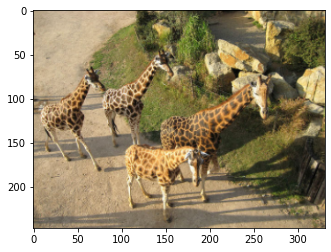

In [11]:
# Print out the image and the generated caption
print (sentence)
image = Image.open(args.image)
plt.imshow(np.asarray(image))
    